# Sentinel-1 products

This section shows the performance of MET Norway for Sentinel-1 products. Both, an overall status and last month status are shown below.

In [1]:
import pathlib
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
from IPython.display import Markdown as md

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams.update({'font.size': 22})

In [2]:
#logsdir = pathlib.Path('/lustre/storeB/project/NBS2/sentinel/production/NorwAREA/netCDFNBS_work/production/monitoring/dhus_queries')
logsdir = pathlib.Path('../data')

In [3]:
def plot_stats(df, plot_max=False, plot_BE=True):

    fig, ax = plt.subplots()  

    #color1 = 'xkcd:sea blue'
    color2 = 'xkcd:brick red'
    color3 = 'xkcd:olive green'
    color4 = 'xkcd:gold'
    color5 = 'xkcd:sea blue'

    plt.plot(df.index, df['scihub'], linestyle='solid', color=color2, label='scihub.copernicus.eu')
    plt.plot(df.index, df['colhub_global'], linestyle='solid', color=color3, label='colhub.met.no')
    if not df['esahub_global'].isnull().all() and not (df['esahub_global'] == 0).all():
        plt.plot(df.index, df['esahub_global'], linestyle='solid', color=color4, label='sentinelhub2.met.no')
    if not (df['colhub_AOI'] == 0).all():
        plt.plot(df.index, df['colhub_AOI'], linestyle='solid', color=color4, label='colhub-archive.met.no')
    if 'BE' in df and plot_BE:
        plt.plot(df.index, df['BE'], linestyle='solid', color=color5, label='MET Norway BE')
    
    if plot_max == True:
        days = [1]
    elif plot_max == False:
        days = [1,10,20]
    
    ax.set_ylabel('Number of products per sensing day')
    ax.tick_params('y')
 
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=days))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.tick_params(axis='x', rotation=70)
    fig.autofmt_xdate()
    
    plt.legend(loc="best")
    plt.grid(True)
    
    plt.show()

In [4]:
def plot_missing(df, plot_max=False):
    
    # Number of missing products
    missing_all = int(sum(df['scihub'] - df['colhub_global']))
    missing_perc_all = ((df['scihub'] - df['colhub_global'])/df['scihub'])
    
    missing_30 = int(sum((df['scihub'] - df['colhub_global']).iloc[-30]))
    missing_perc_30 = ((df['scihub'] - df['colhub_global'])/df['scihub']).iloc[-30]
    
    #missing_1 = int((df['scihub'] - df['colhub_global']).iloc[-1])
    #missing_perc_1 = ((df['scihub'] - df['colhub_global'])/df['scihub']).iloc[-1]
    
    plt.figtext(-0.4,0.3, 'Difference between \nscihub and colhub \n (last day) \n\n {:d} products missing \n\n ~{:.1%} of the products'.format(missing, missing_perc, 1/3), color=color2)
    plt.grid(True)
    plt.show()

In [5]:
hubs=['colhub_global', 'scihub', 'esahub_global', 'colhub_AOI']
products=['S1']

In [6]:
data_FE = None
for h in hubs:
    csvfile = logsdir / f'products_in_{h}.csv'
    data_tmp = pd.read_csv(csvfile, header=None, names=['product', 'area', 'sensing_date', f'{h}'], parse_dates=['sensing_date'])
    # If several sensing date exist, keep the most recent one
    data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['sensing_date', 'product', 'area'], keep='last'))
    if h == 'colhub_AOI':
        data_clean['area'] = 'colhub_aoi'
    if data_FE is None:
        data_FE = data_clean
    else:
        data_FE = data_FE.merge(data_clean, on=['sensing_date', 'product', 'area'], how='outer')

In [7]:
data_BE = None
areas = ['AOI']
products=['S1']
for a in areas:
    for p in products:
        csvfile = logsdir / f'products_in_BE_{p}_{a}.csv'
        data_tmp = pd.read_csv(csvfile, header=None, names=['product', 'area', 'sensing_date', 'BE'], parse_dates=['sensing_date'])
        # If several sensing date exist, keep the most recent one
        data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['sensing_date', 'product', 'area'], keep='last'))
        if a == 'AOI':
            data_clean['area'] = 'colhub_aoi'
        if data_BE is None:
            data_BE = data_clean
        else:
            data_BE = data_BE.append(data_clean)

In [8]:
data = data_FE.merge(data_BE, on=['sensing_date', 'product', 'area'], how='outer')
# 2022-04-07 - BE are now in more secure network so unavailable for direct queries, so only check FE data
#data = data_FE
data.set_index('sensing_date', inplace=True)
data.sort_index(inplace=True)
data.fillna(0, inplace=True)
#print(data.loc[data.index >= (dt.datetime.today() - dt.timedelta(days=2))].sort_values(['area', 'product'], axis=0, ascending=False))

## Products on portals

The following section contains an update on the Sentinel-1 products included in the different FEs and BEs.

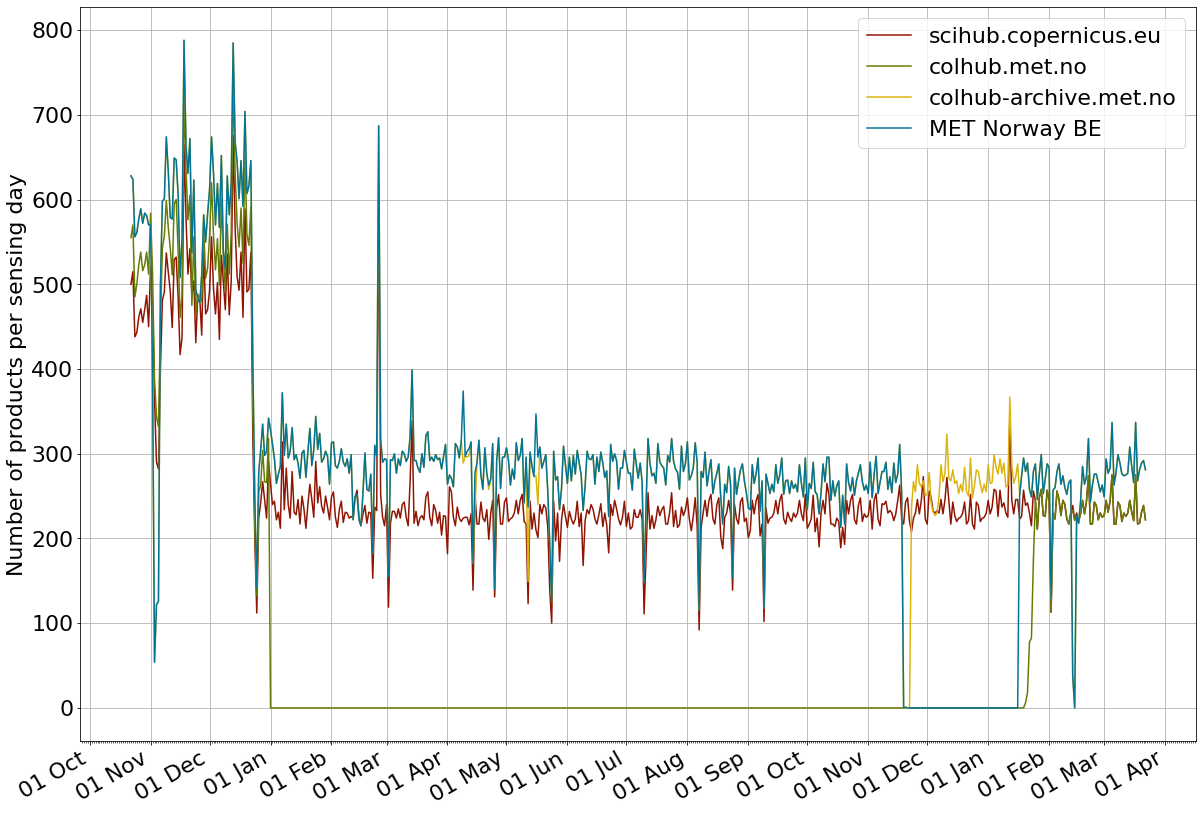

In [9]:
mask = (data['product'] == 'S1') & (data['area'] == 'colhub_aoi')
plot_stats(data.loc[mask], plot_max = True)


The figure above represents the overall number of products present in the different BackEnds and FrontEnds per day for Sentinel-1.

While the figure below shows a zoom on the last 30 days.

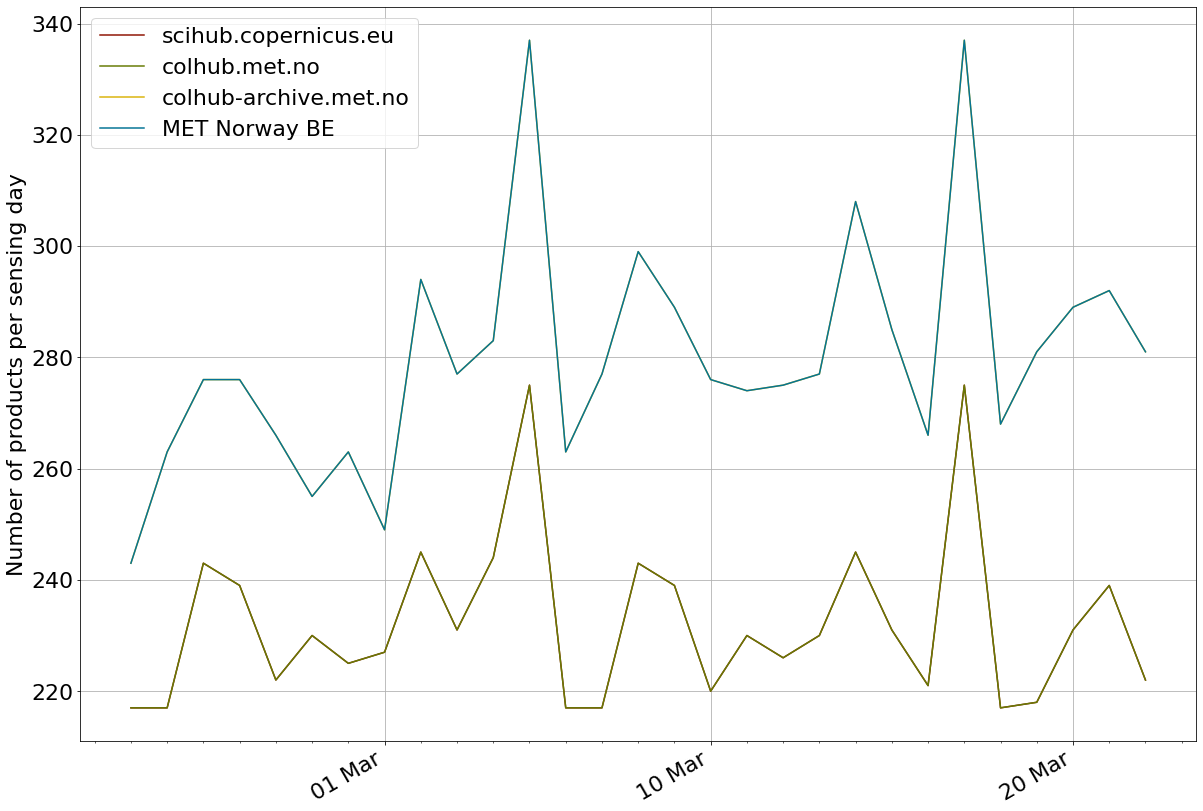

In [10]:
latest = data.loc[mask][data.loc[mask].index >= (dt.datetime.today() - dt.timedelta(days=30))]
#print('Zoom on the last 30 days')
plot_stats(latest, plot_max = False)


A 30 days table is also included for more detailed information.

In [11]:
data_c = data.loc[mask][-30:][['colhub_global', 'scihub', 'colhub_AOI', 'BE']].copy()
data_c.rename(inplace=True, columns={'colhub_global':'colhub.met.no', 'scihub':'scihub.copernicues.eu', 'colhub_AOI':'colhub-archive.met.no', 'BE':'MET Norway BE'})
data_c
# S1 colhub global FE has more data than esahub global FE and the BE as it contains the KSAT data

,colhub.met.no,scihub.copernicues.eu,colhub-archive.met.no,MET Norway BE
sensing_date,,,,
2023-02-21,274,274.0,318.0,318.0
2023-02-22,217,217.0,243.0,243.0
2023-02-23,217,217.0,263.0,263.0
2023-02-24,243,243.0,276.0,276.0
2023-02-25,239,239.0,276.0,276.0
2023-02-26,222,222.0,266.0,266.0
2023-02-27,230,230.0,255.0,255.0
2023-02-28,225,225.0,263.0,263.0
2023-03-01,227,227.0,249.0,249.0


## Missing products

In [12]:
# Number of missing products
total_all = int(sum(data['scihub']))
missing_all = int(sum(data['scihub'] - data['colhub_AOI']))
included_perc_all = int(sum(data['colhub_global'])/sum(data['scihub']))*100
missing_perc_all = 100 - included_perc_all

total_30 = int(sum(data['scihub'].iloc[:-30]))
missing_30 = int(sum(data['scihub'].iloc[:-30] - data['colhub_AOI'].iloc[:-30]))
included_perc_30 = int(sum(data['colhub_AOI'].iloc[:-30])/sum(data['scihub'].iloc[:-30]))*100
missing_perc_30 = 100 - included_perc_30


In [13]:
md("The overall total number of Sentinel-1 products is {}. The number of overall Sentinel-1 missing products consists of {} images. This represents that a {}% of the total was included in MET Norway DHR, while a {}% was not included.".format(total_all, missing_all, included_perc_all, missing_perc_all))

The overall total number of Sentinel-1 products is 19337578. The number of overall Sentinel-1 missing products consists of 17785946 images. This represents that a 0% of the total was included in MET Norway DHR, while a 100% was not included.

In [14]:
md("The total number of Sentinel-1 products in the last 30 days is {}. The number of Sentinel-1 missing products during the last 30 days consists of {} images. This represents that a {}% of the total was included in MET Norway DHR, while a {}% was not included.".format(total_30, missing_30, included_perc_30, missing_perc_30))

The total number of Sentinel-1 products in the last 30 days is 19217014. The number of Sentinel-1 missing products during the last 30 days consists of 17674645 images. This represents that a 0% of the total was included in MET Norway DHR, while a 100% was not included.

## Data ingestion

In this section the time difference between sensing time and ingestion time at MET norway is assessed. The ingestion time is the time at which a Sentinel product was downloaded to MET Norway BE and so, it is automatically available in at least one of the MET Norway FEs.

In [15]:
def read_dhus_logs(file):
    data = pd.read_csv(file, header=None, names=['day', 'product_type', 'action', 'size', 'number', 'timeliness']\
                        , parse_dates=['day'])    
    out = {}
    for type in ['synchronized', 'deleted', 'fscanner']:
        d = data[data['action'] == type].drop('action', 1)
        stats_1 = d.groupby(['day']).sum()[['size', 'number']]
        stats_2 = d.groupby(['day']).median()['timeliness']
        stats = stats_1.join(stats_2)
        if len(stats) > 0:
            stats = stats.asfreq('1D', fill_value=0)
        out.update({type: stats})
    #if out['synchronized'].index[-1] != (pd.Timestamp.today().date()  - pd.Timedelta(days=1)):
     #   print('WARNING!!! No data synchronized yesterday!?')
    return out

In [16]:
def read_dhus_logs_details(file):
    data = pd.read_csv(file, header=None, names=['day', 'product_type', 'action', 'size', 'number', 'timeliness']\
                        , parse_dates=['day'], index_col=['day'])
    return data

In [17]:
def plot_stats_logs(synchronized, deleted=None, fscanner=None, plot_max=False):
   
    # Simple stats that will be annotations on the plot
    median = int(synchronized['number'].iloc[0:-2].median())
    last = int(synchronized['number'].iloc[-1])
    t_median = synchronized['timeliness'].iloc[0:-2].median()
    t_last = synchronized['timeliness'].iloc[-1]
    if fscanner is not None:
        fmedian = int(fscanner['number'].iloc[0:-2].median())
        flast = int(fscanner['number'].iloc[-1])
        ft_median = fscanner['timeliness'].iloc[0:-2].median()
        ft_last = fscanner['timeliness'].iloc[-1]

    fig, ax = plt.subplots()  

    color1 = 'xkcd:sea blue'
    color2 = 'xkcd:brick red'
    color3 = 'xkcd:light blue'

    # Plot timeliness
    plt.plot(synchronized.index, synchronized['timeliness'], linestyle='solid', color=color2)
    ax.set_ylim([0, None]) 
    ax.set_ylabel('Timeliness in hours', color=color2)
    ax.tick_params('y', colors=color2)
    plt.grid(True)
    #plt.legend(loc="lower left")
    
    # Plot number of products
    ax2 = ax.twinx()
    plt.plot(synchronized.index, synchronized['number'], color=color1, label='synchronized')
    if fscanner is not None:
        plt.plot(fscanner.index, fscanner['number'], linestyle='dashed', color=color1, label='fscanned')
        plt.legend(loc="upper left")
    if deleted is not None:
        plt.plot(deleted.index, deleted['number'], color=color3, label='deleted')
    plt.legend(loc="best")
    ax2.set_xlabel('Ingestion date in colhub')
    ax2.set_ylabel('Number of products', color=color1)
    ax2.tick_params('y', colors=color1)

    # Add statistics
    #plt.figtext(-0.4,0.8, f'Synchronizers')
    #plt.figtext(-0.4,0.6, 'Timeliness (in hours) \n\n last day {:5.2f} \n median {:5.2f}'.format(t_last, t_median), color=color2)
    #plt.figtext(-0.4,0.4, f'Number of products ingested \n\n last day {last} \n median {median}', color=color1)
    #if fscanner is not None:
     #   plt.figtext(1.2,0.8, f'Fscanners')
      #  plt.figtext(1.2,0.6, 'Timeliness (in hours) \n\n last day {:5.2f} \n median {:5.2f}'.format(ft_last, ft_median), color=color2)
       # plt.figtext(1.2,0.4, f'Number of products ingested \n\n last day {flast} \n median {fmedian}', color=color1)
    
    
    # Time axis formatting
    if plot_max == True:
        days = [1]
    elif plot_max == False:
        days = [1,10,20]
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=days))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.autofmt_xdate()

    plt.show()

In [18]:
def plot_stats_logs_daily(synchronized, deleted=None, fscanner=None, plot_max=False):
   
    # Simple stats that will be annotations on the plot
    median = int(synchronized['number'].iloc[0:-2].median())
    last = int(synchronized['number'].iloc[-1])
    t_median = synchronized['timeliness'].iloc[0:-2].median()
    t_last = synchronized['timeliness'].iloc[-1]
    if fscanner is not None:
        fmedian = int(fscanner['number'].iloc[0:-2].median())
        flast = int(fscanner['number'].iloc[-1])
        ft_median = fscanner['timeliness'].iloc[0:-2].median()
        ft_last = fscanner['timeliness'].iloc[-1]

    fig, ax = plt.subplots()  

    color1 = 'xkcd:sea blue'
    color2 = 'xkcd:brick red'
    color3 = 'xkcd:light blue'

    # Plot timeliness
    plt.plot(synchronized.index, synchronized['timeliness'], linestyle='solid', color=color2)
    ax.set_ylim([0, None]) 
    ax.set_ylabel('Timeliness in hours', color=color2)
    ax.tick_params('y', colors=color2)
    plt.grid(True)
    #plt.legend(loc="lower left")
    
    # Plot number of products
    ax2 = ax.twinx()
    plt.plot(synchronized.index, synchronized['number'], color=color1, label='synchronized')
    if fscanner is not None:
        plt.plot(fscanner.index, fscanner['number'], linestyle='dashed', color=color1, label='fscanned')
        plt.legend(loc="upper left")
    if deleted is not None:
        plt.plot(deleted.index, deleted['number'], color=color3, label='deleted')
    plt.legend(loc="best")
    ax2.set_xlabel('Ingestion date in colhub')
    ax2.set_ylabel('Number of products', color=color1)
    ax2.tick_params('y', colors=color1)

    # Add statistics
    #plt.figtext(-0.4,0.8, f'Synchronizers')
    #plt.figtext(-0.4,0.6, 'Timeliness (in hours) \n\n last day {:5.2f} \n median {:5.2f}'.format(t_last, t_median), color=color2)
    #plt.figtext(-0.4,0.4, f'Number of products ingested \n\n last day {last} \n median {median}', color=color1)
    #if fscanner is not None:
     #   plt.figtext(1.2,0.8, f'Fscanners')
      #  plt.figtext(1.2,0.6, 'Timeliness (in hours) \n\n last day {:5.2f} \n median {:5.2f}'.format(ft_last, ft_median), color=color2)
       # plt.figtext(1.2,0.4, f'Number of products ingested \n\n last day {flast} \n median {fmedian}', color=color1)
    
    
    # Time axis formatting
    if plot_max == True:
        days = [1]
    elif plot_max == False:
        days = [1,10,20]
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=days))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.autofmt_xdate()
    
    plt.show()

In [19]:
def plot_stats_simple(df, plot_max=False):

    fig, ax = plt.subplots()  

    color1 = 'xkcd:brick red'

    # Plot nb of products
    plt.plot(df.index, df['nb_products'], linestyle='solid', color=color1)
    ax.set_ylim([0, None]) 
    ax.set_ylabel('Number of products', color=color1)
    ax.tick_params('y', colors=color1)
    
    # Time axis formatting
    if plot_max == True:
        days = [1]
    elif plot_max == False:
        days = [1,10,20]
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=days))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

In [20]:
#csvdir = pathlib.Path('/lustre/storeB/project/NBS2/sentinel/production/NorwAREA/netCDFNBS_work/production/monitoring/dhus_logs')
csvdir = logsdir

/home/albertor/anaconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


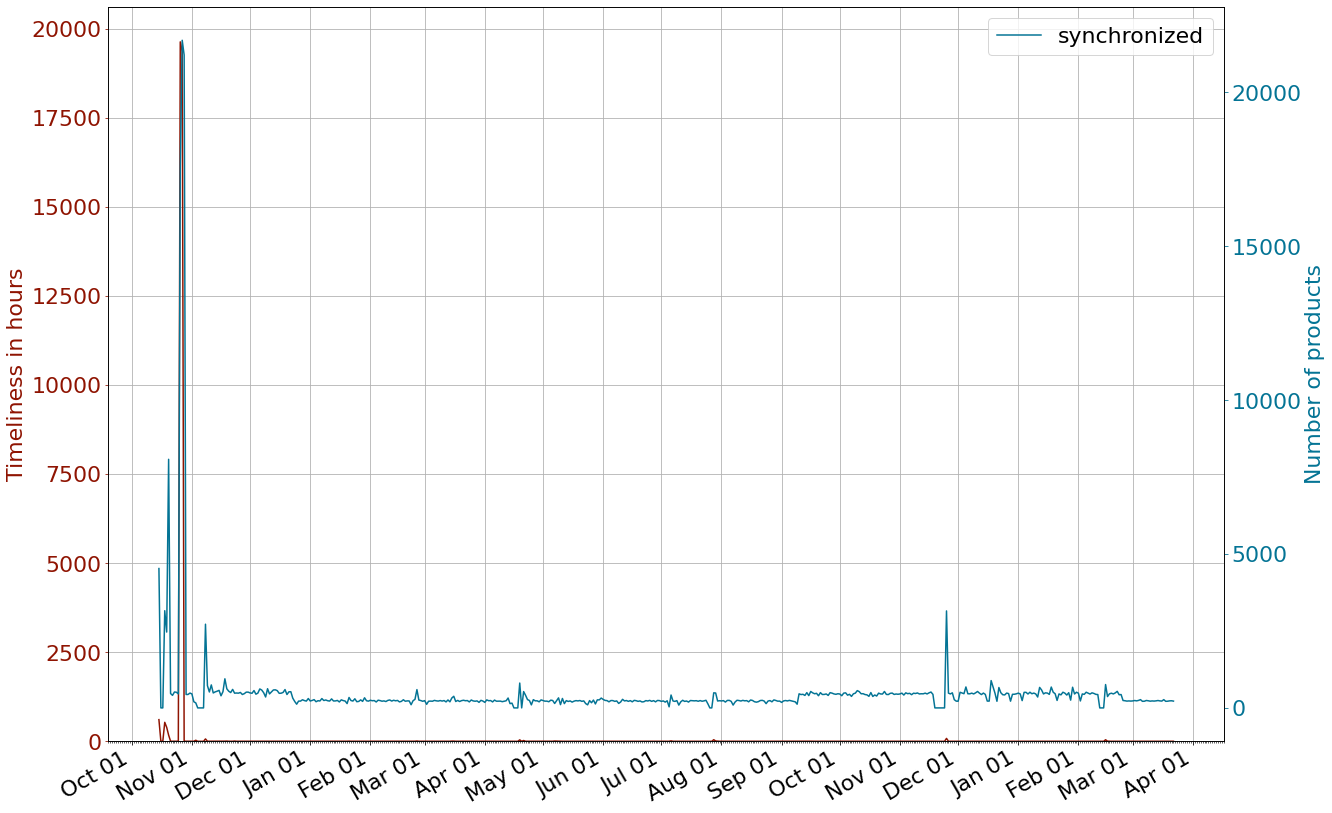

In [21]:
data = read_dhus_logs(csvdir / 'S1-backend-AOI_inputs.csv')
plot_stats_logs(data['synchronized'], plot_max=True)

The figure above shows an overall status of the Sentinel-1 synchronization between ESA datahub and MET Norway BE. The number of products synchronized and deleted are represented by the dark and light blue lines respectively. The red line represents the timeliness.

Following previous sections, the graph below shows a zoom in the last 30 days for the synchronization between ESA datahub and MET Norway BE.

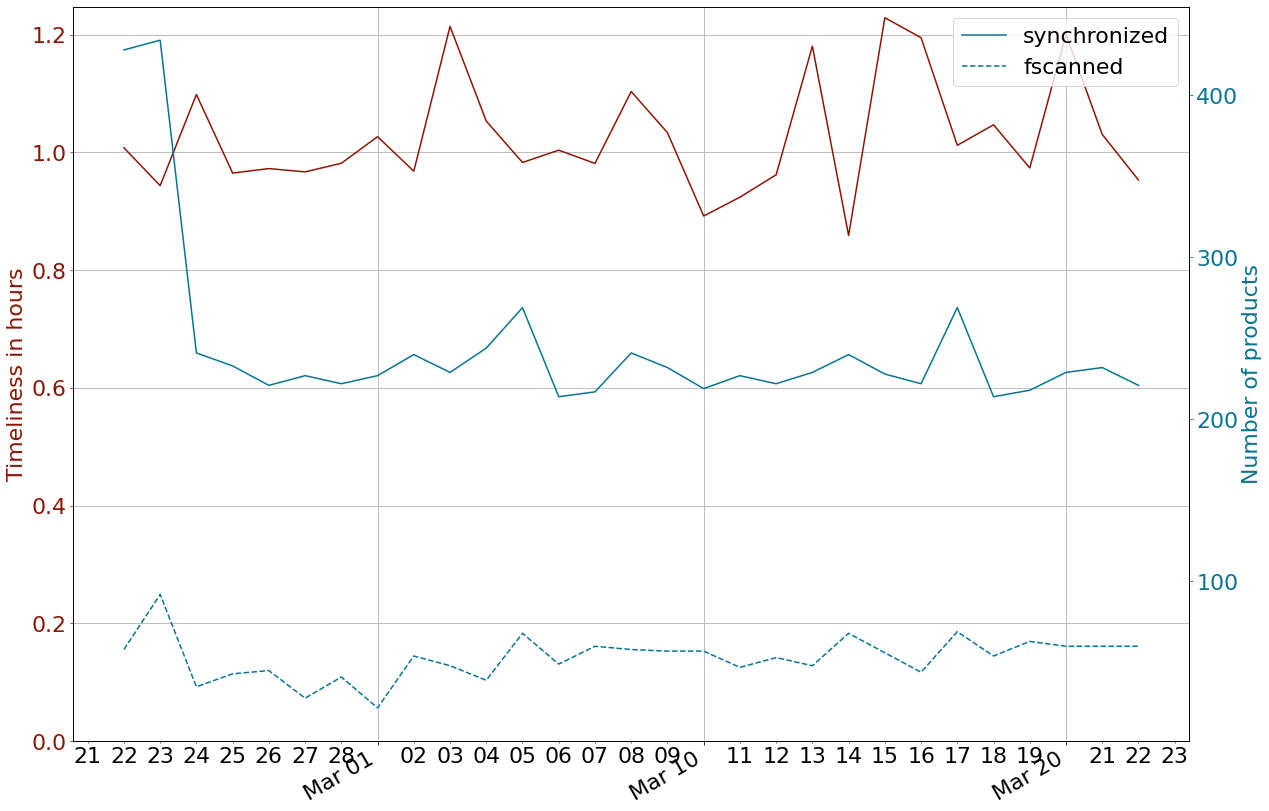

In [22]:
latest = data['synchronized'][data['synchronized'].index >= (dt.datetime.today() - dt.timedelta(days=30))]
latest_fscanner = data['fscanner'][data['fscanner'].index >= (dt.datetime.today() - dt.timedelta(days=30))]
#print('Zoom on the last 30 days')
plot_stats_logs_daily(latest, fscanner=latest_fscanner, plot_max=False)

A more detailed information is given in the table below where the last 30 days are assessed for products synchronized from ESA.

In [23]:
#print('Numbers for the last 5 days')
data['synchronized'].iloc[-30:]

,size,number,timeliness
day,,,
2023-02-21,809.782044,538,1.055980
2023-02-22,555.152719,428,1.007855
2023-02-23,665.636327,434,0.943607
2023-02-24,324.471212,241,1.098394
2023-02-25,357.326604,233,0.964938
2023-02-26,312.543234,221,0.972552
2023-02-27,294.556438,227,0.966954
2023-02-28,332.357513,222,0.981584
2023-03-01,307.454872,227,1.026707


It is also given extra information in the table below where the last 30 days are assessed for products syncronized from KSAT.

In [24]:
data['fscanner'].iloc[-30:]

,size,number,timeliness
day,,,
2023-02-21,124.532089,100,0.716167
2023-02-22,63.437141,58,0.589826
2023-02-23,98.826436,92,0.608005
2023-02-24,46.826358,35,0.565835
2023-02-25,49.449436,43,0.616754
2023-02-26,57.736904,45,0.730772
2023-02-27,32.247418,28,0.554693
2023-02-28,49.117150,41,0.653978
2023-03-01,26.598833,22,0.693417
